<a href="https://colab.research.google.com/github/JinGunseon/FinanceDataAnalysis/blob/main/%EC%8B%A4%EC%8A%B5_Linear_Regression%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%B1%84%EA%B6%8C_%EC%88%98%EC%9D%B5%EB%A5%A0_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 채권 수익률 예측 Machine Learning Model

채권 가격을 예측하는 머신 러닝 모델을 작성하려면 먼저 채권 가격에 영향을 미치는 변수들을 수집하고, 이를 기반으로 모델을 학습시켜야 합니다. 일반적으로 채권 가격은 **이자율**, **만기 기간**, **신용 등급**, **쿠폰 금리**, **유동성** 등 다양한 요인에 의해 결정됩니다. 이 예제에서는 간단하게 경제 지표와 소비자 물가 지수를 이용하여 채권 수익률을 예측하는 회귀 모델을 구축하겠습니다.

아래 예제에서는 머신 러닝 회귀 모델 중 하나인 `RandomForestRegressor`를 사용하겠습니다. 또한, Python의 `scikit-learn`과 `pandas` 라이브러리를 사용하여 데이터를 전처리하고 모델을 학습시킵니다.

### 예제 코드: 미국 10년 만기 국채 수익률 예측

1. **데이터 수집**:
   - 미국 10년 만기 국채 수익률 (10Y Treasury Yield)을 가져옵니다.
   - S&P 500 지수와 소비자 물가지수(CPI) 데이터를 가져와 경제 지표로 활용합니다.
   - 여기서 `10Y_Treasury_Yield`는 금리에 해당하며, `SP500`와 `CPI`는 경기를 반영하는 추가 변수로 사용됩니다.
<br>
<br>
3. **모델 학습**:
   - 예측 변수(`X`)로 S&P 500 지수, CPI를 사용하고, 타깃 변수(`y`)로 채권 수익률을 설정합니다.

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import datetime

In [2]:
# 데이터 수집 기간 설정
start_date = "2010-01-01"
end_date = datetime.datetime.today().strftime("%Y-%m-%d")  # 현재 날짜를 YYYY-MM-DD 형식으로 설정


# 미국 10년 만기 국채 수익률 데이터 가져오기 (FRED 데이터)
treasury_yield = pdr.get_data_fred("DGS10", start=start_date, end=end_date)['DGS10']
print(treasury_yield.shape)
treasury_yield.head()

(4009,)


,DGS10
DATE,
2010-01-01,NaN
2010-01-04,3.85
2010-01-05,3.77
2010-01-06,3.85
2010-01-07,3.85


In [3]:
# S&P 500 데이터 가져오기 (경기 지표로 사용)
sp500 = yf.download("^GSPC", start=start_date, end=end_date, multi_level_index=False)['Close']
print(sp500.shape)
sp500.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

(3866,)


,Close
Date,
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980


In [4]:
# 기타 경제 지표 예시로 소비자 물가지수 (CPI) 가져오기
cpi = pdr.get_data_fred("CPIAUCSL", start=start_date, end=end_date)['CPIAUCSL']

cpi = cpi.resample('D').interpolate(method='linear')

print(cpi.shape)
cpi.head()

(5570,)


,CPIAUCSL
DATE,
2010-01-01,217.488000
2010-01-02,217.481323
2010-01-03,217.474645
2010-01-04,217.467968
2010-01-05,217.461290


In [5]:
# 데이터 합치기
data = pd.concat([treasury_yield, sp500, cpi], axis=1)
data.columns = ['10Y_Treasury_Yield', 'SP500', 'CPI']
data.dropna(inplace=True)  # 결측치 제거

print(data.shape)
data.head()

(3807, 3)


,10Y_Treasury_Yield,SP500,CPI
2010-01-04,3.85,1132.989990,217.467968
2010-01-05,3.77,1136.520020,217.461290
2010-01-06,3.85,1137.140015,217.454613
2010-01-07,3.85,1141.689941,217.447935
2010-01-08,3.83,1144.979980,217.441258


In [6]:
# 타겟 변수 설정: 10년 만기 국채 수익률 (10Y Treasury Yield)
y = data['10Y_Treasury_Yield']

# 예측 변수로 '10Y_Treasury_Yield'를 제외한 다른 경제 지표들 사용
X = data[['SP500', 'CPI']]

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3045, 2), (762, 2), (3045,), (762,))

In [8]:
import warnings
warnings.filterwarnings('ignore')

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)
y_pred.shape

(762,)

In [9]:
# 모델 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 예측 결과 일부 출력
results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(results.head())

Mean Squared Error: 0.018357481246719185
R^2 Score: 0.9776117948430888
            Actual  Predicted
2014-01-22    2.87     2.8278
2022-09-27    3.97     3.8190
2023-06-01    3.61     3.7202
2013-08-06    2.67     2.5911
2019-03-11    2.64     2.5857


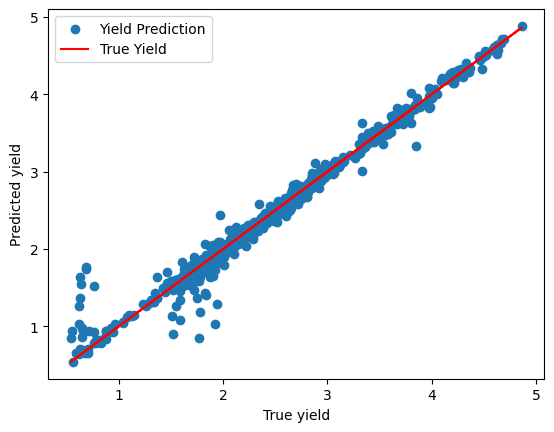

In [10]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, label='Yield Prediction')
plt.plot(y_test, y_test, 'r', label='True Yield')
plt.xlabel('True yield')
plt.ylabel('Predicted yield')
plt.legend()
plt.show()

In [11]:
# 오늘 날짜 데이터 수집
today = datetime.datetime.today().strftime("%Y-%m-%d")
sp500_today = yf.download("^GSPC", period="1d", progress=False, multi_level_index=False)['Close'].iloc[-1]
cpi_latest = cpi.iloc[-1]  # 가장 최근의 CPI 데이터 사용

# 오늘 데이터로 예측
today_data = pd.DataFrame({'SP500': [sp500_today], 'CPI': [cpi_latest]})
predicted_yield = model.predict(today_data)[0]

print(f"Predicted 10-Year Treasury Yield for {today}: {predicted_yield:.2f}%")

Predicted 10-Year Treasury Yield for 2025-05-16: 4.40%


In [12]:
treasury_yield.tail()

,DGS10
DATE,
2025-05-08,4.37
2025-05-09,4.37
2025-05-12,4.45
2025-05-13,4.49
2025-05-14,4.53



### 해석 방법:

1. **오늘의 실제 시장 수익률이 모델 예측 수익률보다 높을 때**:
   - 채권 수익률이 **고평가**되었다고 볼 수 있습니다.
   - 이는 시장이 채권의 위험을 더 크게 평가하고 있다는 뜻으로 해석될 수 있습니다.
   - 이 경우, 채권 가격은 상대적으로 낮게 거래되고 있을 가능성이 있습니다.

2. **오늘의 실제 시장 수익률이 모델 예측 수익률보다 낮을 때**:
   - 채권 수익률이 **저평가**되었다고 볼 수 있습니다.
   - 이는 시장이 채권의 위험을 더 낮게 평가하고 있다는 뜻으로 해석될 수 있습니다.
   - 이 경우, 채권 가격은 상대적으로 높게 거래되고 있을 가능성이 있습니다.

---

### 왜 이런 해석이 가능한가?

- **채권 가격과 수익률의 관계**: 채권 가격과 수익률은 반비례 관계에 있습니다. 시장 수익률이 높다면 채권 가격은 낮아지고, 수익률이 낮다면 채권 가격은 높아집니다.
- **모델의 역할**: 모델은 과거 데이터와 경제 지표를 기반으로 "합리적인 수익률"을 예측합니다. 따라서 실제 시장 수익률이 모델 수익률보다 높다면, 시장이 그만큼 위험을 더 반영하고 있는 것으로 볼 수 있습니다.

---

### 예제 시나리오:
- **모델 예측 수익률**: 3.5%
- **오늘의 시장 수익률**: 4.0%
  - 실제 시장 수익률이 더 높으므로, **채권 수익률이 고평가**되었음을 의미합니다.
  - 이 경우, 투자자들은 채권을 저평가된 것으로 간주하고 매수 기회를 찾을 수 있습니다.

반대로, 시장 수익률이 3.0%라면 채권은 **저평가**된 것으로 간주할 수 있습니다.

---

### 결론:
- **모델 예측 vs 실제 시장 수익률** 비교는 투자 판단에 중요한 참고 지표가 됩니다.
- 다만, 시장 수익률이 높거나 낮은 이유에는 금리 변화, 유동성, 위험 선호도 등 다양한 요인이 포함되므로, 이러한 외부 요인도 함께 고려해야 합니다.